# Project Overview
The goal of this project is to develop an accurate model trained on U.S. county-level data to predict monthly microbusiness density in a given area. This would potentially help policymakers gain visibility into microbusinesses, a growing trend of very small entities. Additional information will enable new policies and programs to improve the success and impact of these smallest of businesses.
More detailed information about the dataset and objective can be found [on Kaggle](https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/overview).
**The dataset consists of monthly microbusiness data for US counties from 2019 to 2022 (39 months), and the goal is to forecast next 8 months' microbusiness density for each county.**


For this project, we will replicate a **deep neural architecture based on backward and forward residual links and a very deep stack of fully-connected layers** as given in [N-BEATS: Neural basis expansion analysis for interpretable time series forecasting](https://arxiv.org/abs/1905.10437) paper. We will make our predictions using an **ensemble** of deep neural networks trained with different hyperparameters and different length of past history. The model is evaluated using symmetric mean absolute percentage error(**sMAPE**) because the scale of microbusiness density data is different for different counties.


Below is the abstract of the paper for reference. 

```We focus on solving the univariate times series point forecasting problem using deep learning. We propose a deep neural architecture based on backward and forward residual links and a very deep stack of fully-connected layers. The architecture has a number of desirable properties, being interpretable, applicable without modification to a wide array of target domains, and fast to train. We test the proposed architecture on several well-known datasets, including M3, M4 and TOURISM competition datasets containing time series from diverse domains. We demonstrate state-of-the-art performance for two configurations of N-BEATS for all the datasets, improving forecast accuracy by 11% over a statistical benchmark and by 3% over last year's winner of the M4 competition, a domain-adjusted hand-crafted hybrid between neural network and statistical time series models. The first configuration of our model does not employ any time-series-specific components and its performance on heterogeneous datasets strongly suggests that, contrarily to received wisdom, deep learning primitives such as residual blocks are by themselves sufficient to solve a wide range of forecasting problems. Finally, we demonstrate how the proposed architecture can be augmented to provide outputs that are interpretable without considerable loss in accuracy.```


# Load and Preprocess Data

In [ ]:
# Load train and test dataframes
train = pd.read_csv('train_godaddy.csv', parse_dates = ['first_day_of_month']).rename(columns = {'first_day_of_month':'date'})
test = pd.read_csv('test_godaddy.csv', parse_dates = ['first_day_of_month']).rename(columns = {'first_day_of_month':'date'})
# View first 5 rows
train.sort_values(by = ['cfips', 'date'], ascending = [True, True], inplace = True)
train.head()

,row_id,cfips,county,state,date,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [ ]:
# Get min and max, number of unique dates
print(f'First date of train: {train.date.min()}')
print(f'Last date of train: {train.date.max()}')
print(f'Number of train time steps: {train.date.nunique()}')
print(f'Forecast Horizon (test time steps): {test.date.nunique()}')

First date of train: 2019-08-01 00:00:00
Last date of train: 2022-10-01 00:00:00
Number of train time steps: 39
Forecast Horizon (test time steps): 8


In [ ]:
# Get microbusiness data into shape (n_cfips, n_time_steps)
data = []
cfips = []
for cfip in set(train.cfips):
  data.append(train[train.cfips == cfip].microbusiness_density.values)
  cfips.append(cfip)

# Create a dataframe from the microbusiness data
cols = [f'time_{i+1}' for i in range(39)]
train_df = pd.DataFrame(data, columns = cols)
train_df.index = cfips
train_df.head()

,time_1,time_2,time_3,time_4,time_5,time_6,time_7,time_8,time_9,time_10,...,time_30,time_31,time_32,time_33,time_34,time_35,time_36,time_37,time_38,time_39
41001,2.491436,2.771722,2.592650,2.639365,2.654936,2.741322,2.764619,2.733556,2.787916,2.842277,...,3.332045,3.316583,3.339776,3.308852,3.308852,3.347507,3.486664,3.448009,3.424816,3.432547
41003,5.651493,5.617473,5.628359,5.612030,5.590257,5.472544,5.392497,5.395165,5.491221,5.513902,...,4.922766,4.940893,4.965494,4.962904,4.929240,4.938303,5.008222,4.984916,4.986210,5.004337
41005,10.027122,10.379560,10.385016,10.381165,10.355486,10.151243,10.057525,10.131679,10.280934,10.281566,...,10.544278,10.547347,10.602899,10.641569,10.552872,10.652004,10.852725,10.808837,10.888941,10.929760
41007,6.555875,6.290893,6.637660,6.356320,6.405391,6.631026,6.441016,6.508647,6.331519,6.241345,...,6.283227,6.317426,6.354734,6.326753,6.326753,6.336080,6.354734,6.311208,6.261464,6.292554
41009,4.033103,4.104621,4.094404,4.107175,4.107175,4.057825,4.005028,4.017599,3.942175,3.954746,...,3.951235,3.960949,3.990092,4.002235,3.985234,3.992520,4.048377,4.198946,4.291231,4.269374


In [ ]:
# Check irregular data and delete if exist
print(f'There is {(train_df.iloc[:,-1]==0).sum()} irregular observation') # zero business at the last period

# We remove this row because it will cause a problem in calculating MAPE error (division by 0)
train_df = train_df[train_df.time_39!=0]
train_df.shape

There is 0 irregular observation


(3134, 39)

In [ ]:
# Create window and labels
horizon = 8
X, y = train_df.iloc[:,:-horizon].astype(np.float32), train_df.iloc[:,-horizon:].astype(np.float32)
X.shape, y.shape

# Create train and test sets assuming the data distribution is the same for all counties 
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((2507, 31), (627, 31), (2507, 8), (627, 8))

In [ ]:
# Create tf.data.Dataset for fast loading
BATCH_SIZE = 1024   # batch size is set the same as given in Table 18 of the paper
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 31), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 31), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>)

In [ ]:
# Create a function to do all the above steps
def make_train_test_datasets(train_df, window_size, horizon = 2, batch_size = 1024, test_size = 0.2):
    X, y = train_df.iloc[:,-horizon-window_size:-horizon].astype(np.float32), train_df.iloc[:,-horizon:].astype(np.float32)
    X.shape, y.shape

    # Create train and test sets assuming the data distribution is the same for all counties 
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = test_size, random_state=42)

    # Create tf.data.Dataset for fast loading
    train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    print(f'Train data shapes: input - {train_x.shape}, label - {train_y.shape}')
    return test_y, train_dataset, test_dataset


# Create custom sMAPE loss and metric

In [ ]:
# Create a function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
  """
  Calculates forecast metrics for multihorizon predictions.
  """
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # mean squared error
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred) # mean absolute error
  rmse = tf.sqrt(mse) # root mean squared error
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred) # mean absolute percentage error
  if mae.ndim >0: # for handling multi-horizon forecasts
    mse = tf.reduce_mean(mse)
    mae = tf.reduce_mean(mae)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
  return  {'mse':mse.numpy(),
           'mae': mae.numpy(),
           'rmse': rmse.numpy(),
           'mape': mape.numpy()}

# Custom sMAPE loss and metric with Subclassing

In [ ]:
class SmapeMetric(tf.keras.metrics.Metric):
  def __init__(self, name='smape', **kwargs):
    super(SmapeMetric, self).__init__(name=name, **kwargs)
    self.smape = self.add_weight(name='smape', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    # Calculate the absolute difference between the true and predicted values
    diff = tf.abs(y_true - y_pred)

    # Calculate the sum of the true and predicted values
    sum = tf.add(tf.abs(y_true), tf.abs(y_pred))/200

    # Calculate the SMAPE error
    error = tf.divide(diff, sum)
    self.smape.assign_add(tf.reduce_mean(error))

  def result(self):
    return self.smape

  def reset_state(self):
    # The state of the metric will be reset at the start of each epoch.
    self.smape.assign(0.0)

In [ ]:
class SMAPELoss(tf.keras.losses.Loss):
  def __init__(self, name='smape_loss'):
    super(SMAPELoss, self).__init__(name=name)

  def call(self, y_true, y_pred):
    # Calculate the absolute difference between the true and predicted values
    diff = tf.abs(y_true - y_pred)

    # Calculate the sum of the true and predicted values
    sum = tf.add(tf.abs(y_true), tf.abs(y_pred))/200

    # Calculate the SMAPE error
    smape_error = tf.divide(diff, sum)

    # Return the mean of the SMAPE error
    return tf.reduce_mean(smape_error)

# Create N-BEATS model

Here we implement the generic version of the NBEATS algorithm given in the paper. Refer to the figure 1 and equation 1 on [page 3](https://arxiv.org/pdf/1905.10437.pdf).

![raw](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-figure-1-nbeats-paper-annotated.png)


In [ ]:
# Create NBEATSblock custom layer
class NBEATSblock(tf.keras.layers.Layer):
  def __init__(self,
              input_size: int, 
              horizon: int,
              n_neurons: int,
              n_layers: int,
              **kwargs):
    super(NBEATSblock, self).__init__()
    self.input_size = input_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers
    
    # Block contains a stack of 4 fully connected layers
    self.hidden = [tf.keras.layers.Dense(n_neurons, 'relu') for _ in range(n_layers)]
    # Output of the block is the Theta layer with linear activation
    self.theta_size = self.input_size + self.horizon
    self.theta = tf.keras.layers.Dense(input_size + horizon, 'linear', name = 'theta')

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    # Linear Projections - predict forward and backward expansion coefficients
    theta = self.theta(x)
    backcast, forecast = theta[:,:self.input_size], theta[:,-self.horizon:] 
    return backcast, forecast
  def get_config(self):
    config = super().get_config()
    config.update({
        'input_size': self.input_size,
        "horizon": self.horizon,
        "n_neurons":self.n_neurons,
        "n_layers":self.n_layers
    })
    return config
  @classmethod
  def from_config(cls, config):
      return cls(**config)


In [ ]:
# Create hyperparameters as given Table 18
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
N_BLOCKS = 1
HORIZON = 8
INPUT_SIZE = 31
THETA_SIZE = INPUT_SIZE + HORIZON

In [ ]:
# Create a function to create model checkpoints
def make_checkpoint(model_name, save_path = 'model_experiments'):
  callback = tf.keras.callbacks.ModelCheckpoint(os.path.join(save_path, model_name),
                                                verbosity = 0,
                                                save_best_only = True,
                                                monitor = 'val_loss')
  return callback
# Create early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                              patience = 100,
                                              restore_best_weights = True)
# Create learning rate reduction callback
lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                  patience = 5,
                                                 factor = 0.2,
                                                  min_lr = 1e-7)

In [ ]:
def create_model(input_size, horizon, n_neurons = 512, n_layers = 4, n_stacks = 30, model_name = None, loss = 'mape'):
  # create custom NBEATS block with paper hyperparams
  custom_block = NBEATSblock(input_size = input_size,
                          horizon = horizon,
                          n_neurons = n_neurons,
                          n_layers = n_layers, name = 'initial_block')
  
  # create input layer for custom block layer
  stack_inputs = tf.keras.layers.Input(shape = [input_size,], name = 'stack_input')

  # create initial backcast and forecast
  residuals, forecast = custom_block(stack_inputs)

  # create a stacks of block layers
  for i,_ in enumerate(range(n_stacks-1)): # first block has already been created
     # use n_beats custom layer to find backcast and forecast
     backcast, block_forecast = NBEATSblock(input_size = input_size,
                                            horizon = horizon,
                                            n_neurons = n_neurons,
                                            n_layers = n_layers, name = f'N_BEATS_block_{i}')(residuals) # pass in residuals
    # Create double residual stacking
     forecast = tf.keras.layers.add([forecast, block_forecast], name = f'add_{i}') # update forecasts
     residuals = tf.keras.layers.subtract([residuals, backcast], name = f'subtract_{i}') # update inputs

  model = tf.keras.Model(stack_inputs, forecast, name = model_name)

  # compile the model with MAE loss
  model.compile(loss = loss, optimizer = 'adam', metrics = [SmapeMetric()])

  return model

In [ ]:
# Create model and print its summary
model_nbeats = create_model(INPUT_SIZE, HORIZON, THETA_SIZE, N_NEURONS, N_LAYERS, N_STACKS, model_name = 'NBEATS1')
model_nbeats.summary()

Model: "nbeats_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 31)]         0           []                               
                                                                                                  
 NBEATS1 (NBEATSblock)          ((None, 31),         824359      ['stack_input[0][0]']            
                                 (None, 8))                                                       
                                                                                                  
 N_BEATS_block_0 (NBEATSblock)  ((None, 31),         824359      ['NBEATS1[0][0]']                
                                 (None, 8))                                                       
                                                                                       

In [ ]:
# Fit the model
model_nbeats.fit(train_dataset,
          epochs = N_EPOCHS,
          validation_data = test_dataset,
          callbacks = [early_stop, lr_plateau, make_checkpoint( model_nbeats.name)])

Epoch 1/5000
5/5 [==============================] - 100s 9s/step - loss: 11.1586 - mape: 1151789.3750 - val_loss: 0.6748 - val_mape: 17.8279 - lr: 0.0010
Epoch 2/5000
5/5 [==============================] - 0s 91ms/step - loss: 2.0664 - mape: 89613.6406 - val_loss: 1.4045 - val_mape: 41.7017 - lr: 0.0010
Epoch 3/5000
5/5 [==============================] - 0s 74ms/step - loss: 0.8450 - mape: 230347.4531 - val_loss: 0.8187 - val_mape: 24.2558 - lr: 0.0010
Epoch 4/5000
5/5 [==============================] - 28s 7s/step - loss: 0.7278 - mape: 169657.7031 - val_loss: 0.5112 - val_mape: 10.1156 - lr: 0.0010
Epoch 5/5000
5/5 [==============================] - 27s 7s/step - loss: 0.4273 - mape: 111942.7109 - val_loss: 0.3472 - val_mape: 6.8197 - lr: 0.0010
Epoch 6/5000
5/5 [==============================] - 0s 71ms/step - loss: 0.5831 - mape: 86515.1406 - val_loss: 0.4982 - val_mape: 11.8090 - lr: 0.0010
Epoch 7/5000
5/5 

2023-02-03 04:59:42.484699: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55a4ec647e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-03 04:59:42.484737: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla M60, Compute Capability 5.2
2023-02-03 04:59:42.492518: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-03 04:59:42.659121: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-03 04:59:43.170703: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
INFO:tensorflow

In [ ]:
# Evaluate the model on test dataset
model_nbeats.evaluate(test_dataset)

1/1 [==============================] - 0s 53ms/step - loss: 0.2040 - mape: 4.6416


[0.2040065973997116, 4.641558647155762]

In [ ]:
import matplotlib.pyplot as plt
def plot_timeseries(time_steps, price, format = ".", start = 0, end = None, label = None):
  plt.plot(time_steps[start:end], price[start:end], format, label = label)
  if label: plt.legend(fontsize = 10)
  plt.xlabel('Month', fontsize = 10)
  plt.ylabel('Business Density', fontsize = 10)
  plt.grid(True)

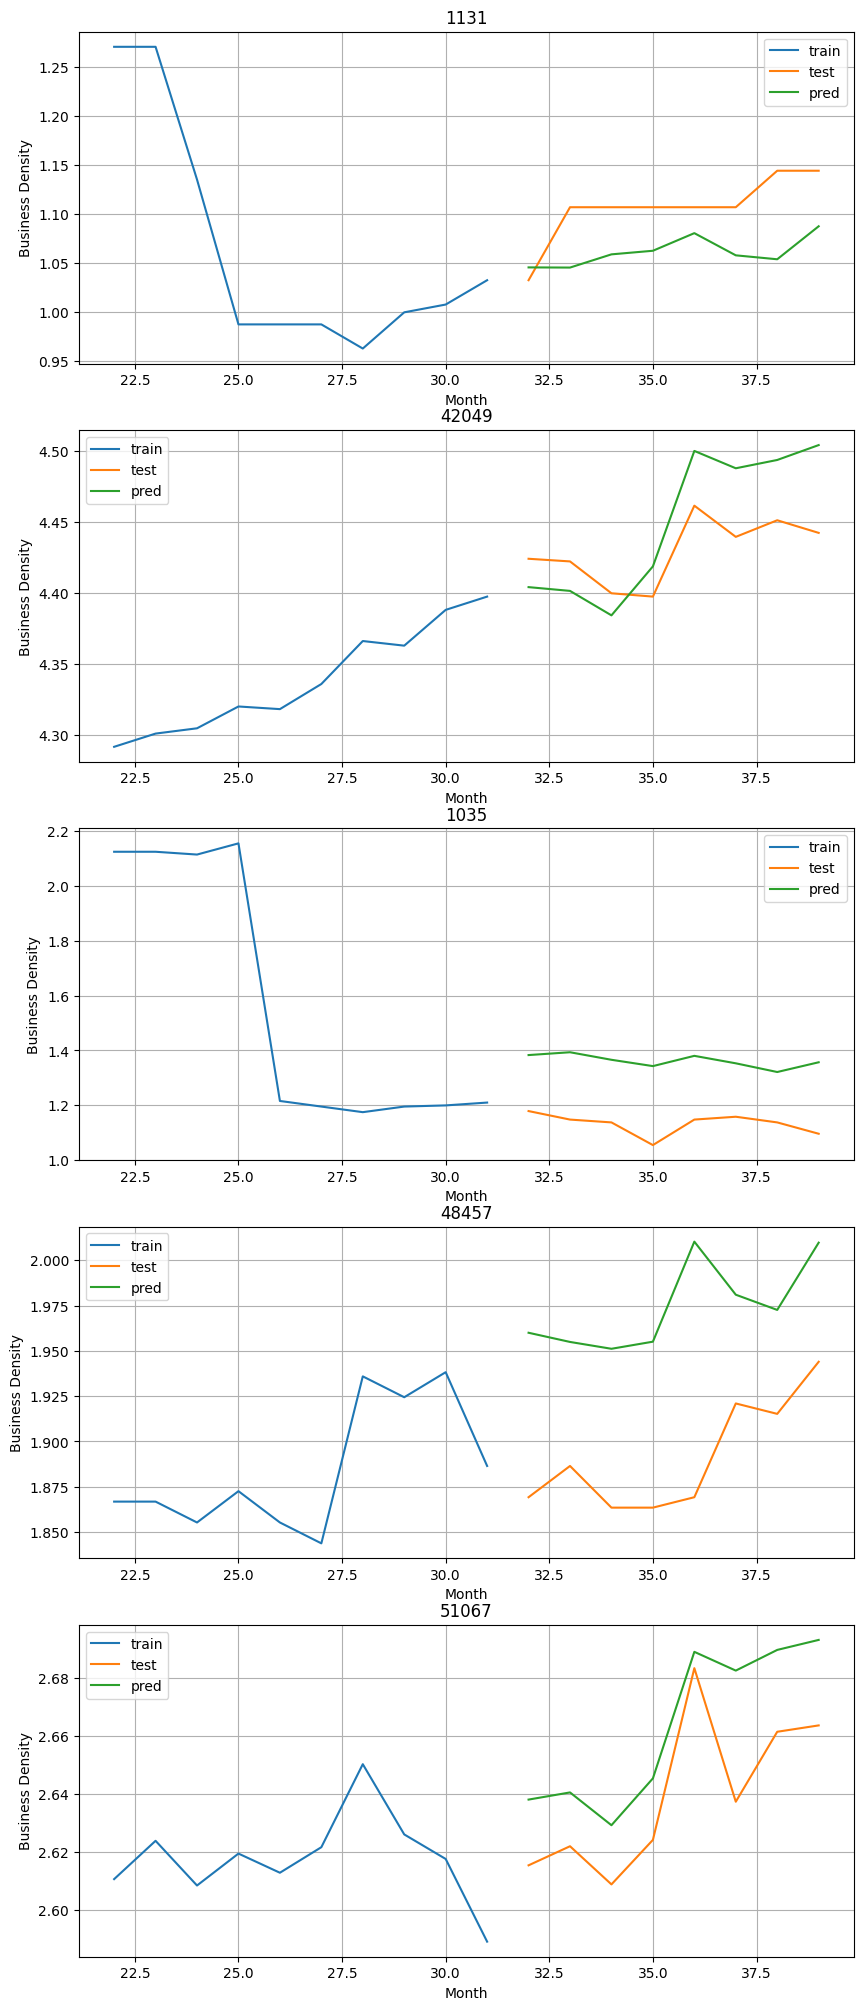

In [ ]:
# Plot inputs and labels for randomly selected county
# Randomly select the county
import random
preds = tf.squeeze(model_nbeats.predict(test_dataset))
plt.figure(figsize = (10,25))
for i in range(5):
  index = random.randint(0, len(test_x))
  input, label, pred = test_x.iloc[index], test_y.iloc[index], preds[index]
  # Plot train, test, and predictions
  plt.subplot(5,1,i+1)
  time_steps = np.arange(1,40)
  plot_timeseries(time_steps[:-HORIZON], input, start = -10, format = '-', label = 'train')
  plot_timeseries(time_steps[-HORIZON:], label, start = -10, format = '-', label = 'test')
  plot_timeseries(time_steps[-HORIZON:], pred, start = -10, format = '-', label = 'pred')
  plt.title(test_x.iloc[index].name)

# Ensemble Learning with N-BEATS Algorithm

As shown in the table 18 of the N-BEATS paper, the writers have built an ensemble of multiple models by differentiating training history length, number of iterations, loss functions, etc. Here, we will also build 10 models with different window size and number of blocks.

In [ ]:
import absl.logging, logging
absl.logging.set_verbosity(absl.logging.ERROR)
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [ ]:
import random
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Create early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_smape',
                                              patience = 300,
                                              restore_best_weights = True)
# Create ensemble of models with different Window Size and Model loss function
models = []
predictions = []
for window_size in [12, 18, 24, 31]:
  for blocks in [30, 40]:
      print('--------------------'*5)
      print(f'Starting to train NBEATS_{window_size}_{blocks}')
      # create data with specific window size
      test_y, train_dataset, test_dataset = make_train_test_datasets(train_df, window_size, horizon = 8, batch_size = 1024, test_size = 0.2)
      # build and fit the model
      model = create_model(window_size, HORIZON, N_NEURONS, N_LAYERS, blocks, model_name = f'NBEATS_{window_size}_{blocks}', loss = 'mape')
      
      # Create learning rate reduction callback (to increase diversity, the factor and patience parameters are assigned randomly)
      ind = random.randint(0,1)
      patiences = [30, 50]
      factors = [0.33, 0.6]
      lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_smape',
                                                  patience = patiences[ind],
                                                 factor = factors[ind],
                                                  min_lr = 1e-7)
      # fit the model                                            
      model.fit(train_dataset,
                epochs = 1000, #  this is 5k in the paper
                validation_data = test_dataset,
                callbacks = [early_stop, lr_plateau, make_checkpoint( model.name)])
      models.append(model)
      # predict the test horizon and append to predictions array
      preds = tf.cast(tf.squeeze(model.predict(test_dataset)), tf.float32)
      predictions.append(preds)
      print(calculate_metrics(tf.squeeze(test_y), preds))
import joblib
joblib.dump(np.array(predictions), 'predictions.pkl')

----------------------------------------------------------------------------------------------------
Starting to train NBEATS_12_30
Train data shapes: input - (2507, 12), label - (2507, 8)
Epoch 1/1000
3/3 [==============================] - 80s 16s/step - loss: 59.8885 - smape: 273.5360 - val_loss: 1072.8225 - val_smape: 167.5640 - lr: 0.0010
Epoch 2/1000
3/3 [==============================] - 26s 13s/step - loss: 454.1357 - smape: 239.1598 - val_loss: 76.1468 - val_smape: 51.8284 - lr: 0.0010
Epoch 3/1000
3/3 [==============================] - 24s 12s/step - loss: 60.2132 - smape: 193.7223 - val_loss: 44.2643 - val_smape: 58.6791 - lr: 0.0010
Epoch 4/1000
3/3 [==============================] - 27s 14s/step - loss: 38.0546 - smape: 123.2760 - val_loss: 19.3115 - val_smape: 20.3474 - lr: 0.0010
Epoch 5/1000
3/3 [==============================] - 26s 13s/step - loss: 25.3703 - smape: 87.0295 - val_l

['predictions.pkl']

In [ ]:
preds = []
for i, window_size in enumerate([12, 18, 24, 31]):
    x = test_x.iloc[:, - window_size :]
    print(x.shape)
    pred = tf.squeeze(models[2*i].predict(x))
    print(calculate_metrics(tf.squeeze(test_y), pred))
    preds.append(pred)
    pred = tf.squeeze(models[2*i+1].predict(x))
    print(calculate_metrics(tf.squeeze(test_y), pred))
    preds.append(pred)

(627, 12)
20/20 [==============================] - 0s 8ms/step
{'mse': 0.44156, 'mae': 0.120898016, 'rmse': 0.14118998, 'mape': 2.8703003}
20/20 [==============================] - 0s 9ms/step
{'mse': 0.99759334, 'mae': 0.1419883, 'rmse': 0.1654135, 'mape': 3.0849888}
(627, 18)
20/20 [==============================] - 0s 7ms/step
{'mse': 2.6648328, 'mae': 0.14587983, 'rmse': 0.1770504, 'mape': 2.8956952}
20/20 [==============================] - 0s 8ms/step
{'mse': 4.9990296, 'mae': 0.15677959, 'rmse': 0.19258474, 'mape': 2.797073}
(627, 24)
20/20 [==============================] - 0s 6ms/step
{'mse': 0.30792883, 'mae': 0.10938746, 'rmse': 0.13336663, 'mape': 2.9950643}
20/20 [==============================] - 0s 8ms/step
{'mse'

In [ ]:
# Calculate the metrics with mean and median predictions
preds = np.array(preds)
mean_pred = np.mean(preds, axis = 0)
median_pred = np.median(preds, axis = 0)
# Get the metrics for the best model
best_preds = preds[3] # based on above output

# Pring best, mean, and median metrics
print('Best', calculate_metrics(tf.squeeze(test_y), best_preds))
print('Mean', calculate_metrics(tf.squeeze(test_y), mean_pred))
print('Median', calculate_metrics(tf.squeeze(test_y), median_pred))


Best {'mse': 4.9990296, 'mae': 0.15677959, 'rmse': 0.19258474, 'mape': 2.797073}
Mean {'mse': 0.6534495, 'mae': 0.116229005, 'rmse': 0.14060268, 'mape': 2.8759005}
Median {'mse': 0.39775768, 'mae': 0.10994609, 'rmse': 0.13242449, 'mape': 2.851314}


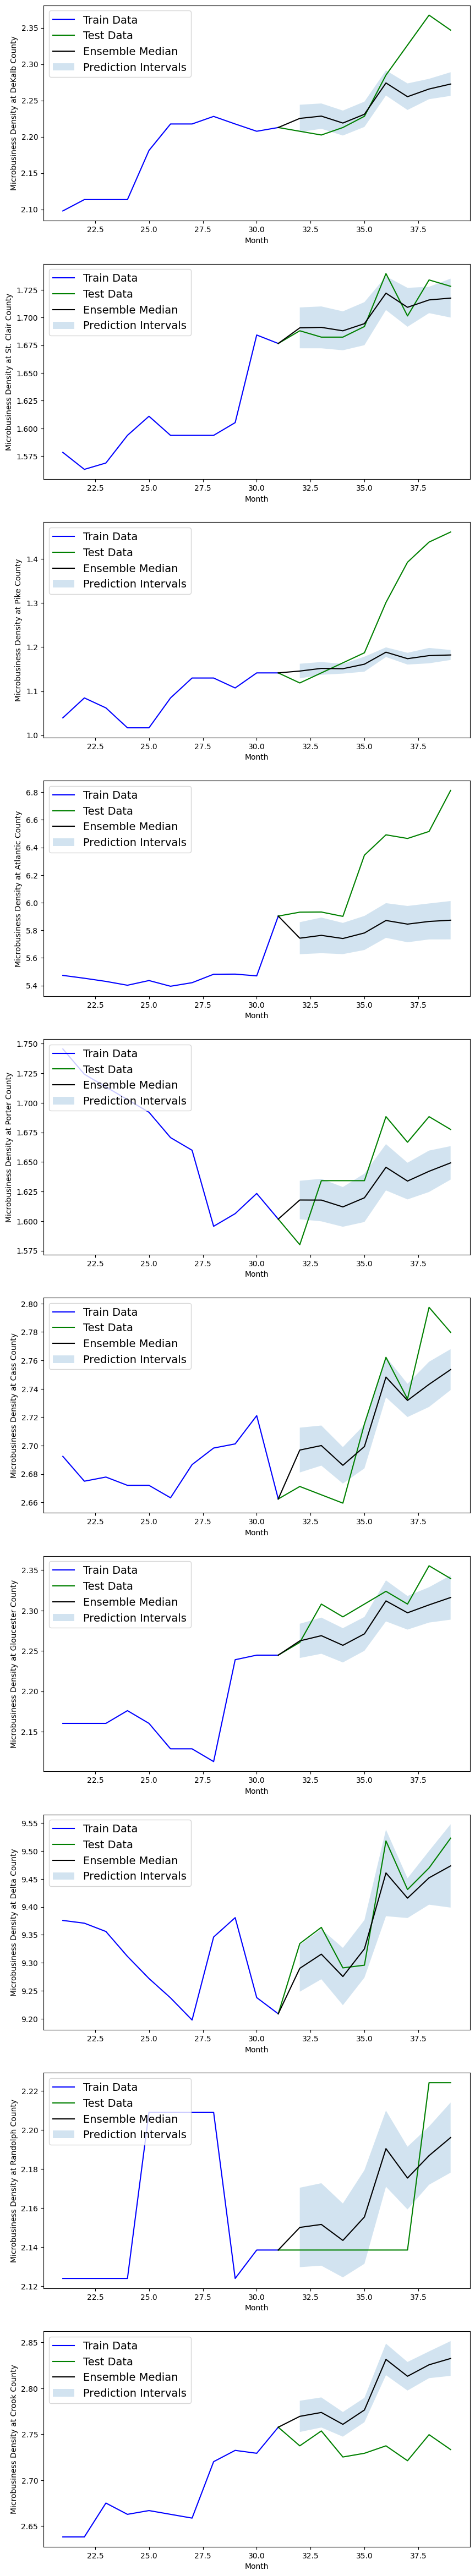

In [ ]:
import matplotlib.pyplot as plt
# Calculate the prediction interval
std_pred = np.std(preds, axis = 0)
lower, upper = median_pred - 1.96*std_pred, median_pred + 1.96*std_pred   # assume gaussian

# Plot prediction interval for 10 random counties
plt.figure(figsize = (10,60))
for i in range(10):
    # Select random county and get labels and predictions
    ind = random.randint(0,len(test_x))
    county = train[train.cfips == train_df.iloc[ind].name].county.values[0] # get county name
    # Get train, test, and predicted values for the county
    past = test_x.iloc[ind]     # train
    last_timestep = past[-1]    # get the last train value 
    recent = np.insert(test_y.iloc[ind].values,0,last_timestep) # test (For better visualisation, we insert the last train value to the front)
    forecast = np.insert(median_pred[ind], 0, last_timestep)    # test prediction
    # Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
    offset=20
    plt.subplot(10,1,i+1)
    plt.plot(np.arange(1,32)[offset:], past[offset:], "b" , label = 'Train Data')
    plt.plot(np.arange(31,40),recent, "g", label="Test Data")
    plt.plot(np.arange(31,40),forecast , "k-", label="Ensemble Median")
    plt.xlabel("Month")
    plt.ylabel(f"Microbusiness Density at {county}")
    plt.fill_between(np.arange(32,40), 
                    (lower[ind]), 
                    (upper[ind]), label="Prediction Intervals", alpha=0.2)
    plt.legend(loc="upper left", fontsize=14);

# Make Future Predictions

In [ ]:
future_preds = []
for i, window_size in enumerate([12,18,24,31]):
    # Prepare input
    input = train_df.iloc[:, -window_size:]
    future_preds.append(tf.squeeze(models[2*i].predict(input)))
    future_preds.append(tf.squeeze(models[2*i+1].predict(input)))

98/98 [==============================] - 1s 8ms/step


In [ ]:
# Get prediction statistics 
future_preds = np.array(future_preds)
preds_median = np.median(future_preds, axis = 0)
preds_mean = np.mean(future_preds, axis = 0)

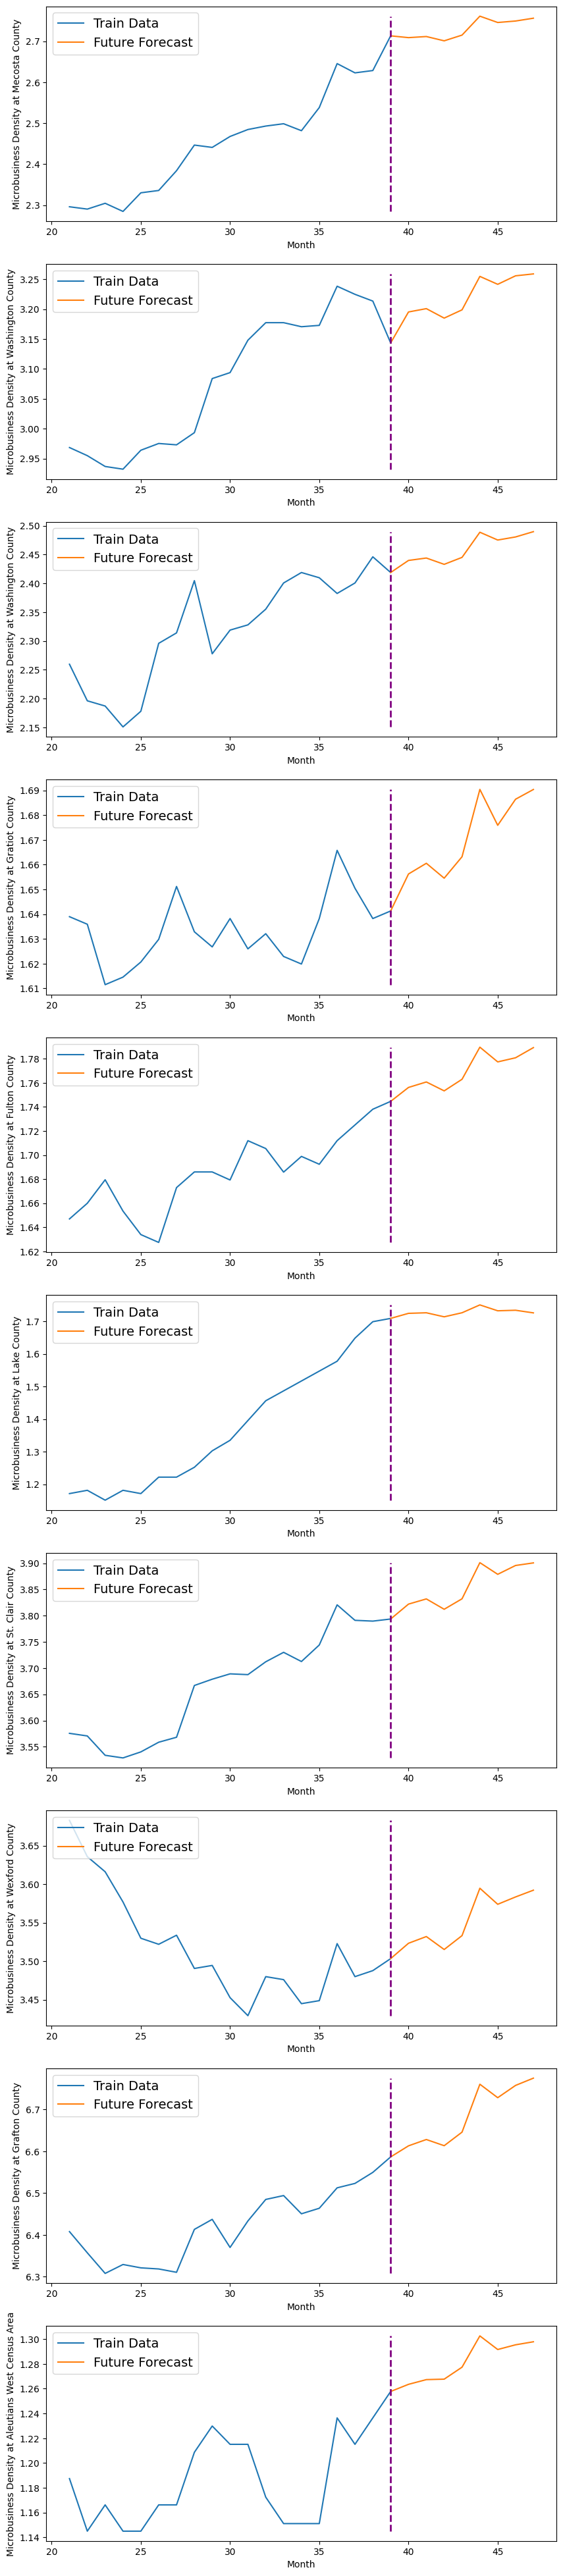

In [ ]:
# Plot future forecast
# Plot prediction interval for 10 random counties
plt.figure(figsize = (10,50))
for i in range(10):
    # Select random county and get labels and predictions
    ind = random.randint(0,len(test_x))
    county = train[train.cfips == train_df.iloc[ind].name].county.values[0] # get county name
    # Get train, test, and predicted values for the county
    past = train_df.iloc[ind]     # train
    last_timestep = past[-1]    # get the last train value 
    forecast = np.insert(preds_median[ind], 0, last_timestep)    # test prediction
    # Plot the forecast 
    offset=20
    plt.subplot(10,1,i+1)
    plt.plot(np.arange(1,40)[offset:], past[offset:], label = 'Train Data')
    plt.plot(np.arange(39,48),forecast, label="Future Forecast")
    plt.vlines(x=[39], ymin=min(min(past[offset:]), min(forecast)), ymax=max(max(past[offset:]), max(forecast)), colors='purple', ls='--', lw=2, label='')
    plt.xlabel("Month")
    plt.ylabel(f"Microbusiness Density at {county}")
    plt.legend(loc="upper left", fontsize=14);